In [1]:
import sys
sys.path.append("models/")

import itertools
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from setup import *
from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo, train_test_split_data
import mnl

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size":12})

%load_ext autoreload
%autoreload 2

# Load Model Embeddings

In [2]:
data_version = '1571'

model_type = 'AE'
sampling = 's'

zoomlevel = 'zoom15'
output_dim = 3
model_run_date = '2208'
v2 = 1

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

In [3]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+
                       "_"+str(v2)+"_"+model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [4]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

In [5]:
demo_cs, demo_np = load_demo(data_dir)
demo = np.hstack((np.array(demo_cs).reshape(-1,1), demo_np))
demo = pd.DataFrame(demo, columns = ['geoid'] + demo_variables)

In [6]:
demo_split = train_test_split_data(demo, data_version='1571')


In [7]:
demo_ct = demo_split['geoid'].to_numpy()
demo_split = demo_split[demo_variables].to_numpy()

In [8]:
model_type = 'SSD'
zoomlevel = 'zoom15'
output_dim = 3
model_run_date = '2208'
v2 = 1

with open(proj_dir+"latent_space/SSD_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+str(v2)+"_"+
                       str(model_run_date)+".pkl", "rb") as f:
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)
    
# Aggregate Embeddings
ct = np.array(ct)
embed_ssd = []
for i in unique_ct:
    embed_ssd.append(np.mean(encoder_output[ct == i], axis=0))
embed_ssd = np.array(embed_ssd)

In [9]:
model_type = 'SAE'
zoomlevel = 'zoom15'
output_dim = 3
model_run_date = '2208'

v1 = 'F'
v2 = 1

weight, lr, wd = get_hp_from_version_code(v1, v2)


with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       v1+"_"+str(v2)+"_"+model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

# Aggregate Embeddings
ct = np.array(ct)
embed_sae = []
for i in unique_ct:
    embed_sae.append(np.mean(encoder_output[ct == i], axis=0))
embed_sae = np.array(embed_sae)

# Load Trip Data

In [10]:
tp = pd.read_csv(data_dir+"trips.csv")
n_alts = 4

In [11]:
print(tp['mode'].value_counts()/len(tp))

2    0.713060
1    0.132001
4    0.111893
3    0.043046
Name: mode, dtype: float64


In [12]:
tp['tract_1'] = tp['state_fips_1'].astype(str) + '_' + tp['county_fips_1'].astype(str)+ '_' + tp['tract_fips_1'].astype(str)
tp['tract_2'] = tp['state_fips_2'].astype(str) + '_' + tp['county_fips_2'].astype(str)+ '_' + tp['tract_fips_2'].astype(str)

tp['morning'] = (tp['dep_hour'] > 6) & (tp['dep_hour'] < 10)
tp['afternoon'] = (tp['dep_hour'] > 15) & (tp['dep_hour'] < 19)
tp['morning'] = tp['morning'].astype(int)
tp['afternoon'] = tp['afternoon'].astype(int)

tp['const'] = 1

def normalize_features(df, cols):
    for c in cols:
        df[c] = df[c]/df[c].max()
    return df

In [13]:
unique_ct = np.array(unique_ct)

x_embed = []
trip_filter = []
x_demo = []
x_ssd = []
x_sae = []
for t1, t2 in zip(tp['tract_1'], tp['tract_2']):
    if sum(unique_ct == t1) == 1 and sum(unique_ct == t2) == 1:
        x_embed.append(np.hstack((aggregate_embeddings[unique_ct == t1], aggregate_embeddings[unique_ct == t2])).flatten())
        x_demo.append(np.hstack((demo_split[demo_ct == t1], demo_split[demo_ct == t2])).flatten())
        x_ssd.append(np.hstack((embed_ssd[unique_ct == t1], embed_ssd[unique_ct == t2])).flatten())
        x_sae.append(np.hstack((embed_sae[unique_ct == t1], embed_sae[unique_ct == t2])).flatten())

        trip_filter.append(True)
    else:
        trip_filter.append(False)
        

In [14]:
trip_filter = np.array(trip_filter)
x_embed = np.array(x_embed, dtype=np.float64)
x_demo = np.array(x_demo, dtype=np.float64)
x_ssd = np.array(x_ssd, dtype=np.float64)
x_sae = np.array(x_sae, dtype=np.float64)

x_trip = tp[['const','morning','afternoon','companion', 'distance', 
         'from_home', 'to_home', 'purp_work', 'purp_school', 'purp_errand', 'purp_recreation', 
         'ontime_important', '12_18yrs', '18_25yrs', '25_55yrs', '55+yrs', 
         'disability', 'educ_col', 'educ_grad', 
         'race_white', 'race_black', 'race_asian', 
         'male', 'female', 
         'emply_park', 'emply_transit', 'emply_veh', 'emply_wfh', 'emply_flex', 'emply_hours', 
         'license', 'person_trips', 'person_transit', 'person_freq_transit', 
         'hh_inc_0_30', 'hh_inc_30_60', 'hh_inc_60_100', 'hh_inc_100_150', 'hh_inc_150', 
         'avg_pr_veh', 'home_own', 'home_house', 'home_condo']].to_numpy()[trip_filter]

In [15]:
y = tp['mode'].astype(int).to_numpy() - 1
y = y[trip_filter]

origins = tp['tract_1'].to_numpy()[trip_filter]
destinations = tp['tract_2'].to_numpy()[trip_filter]

### Model Option
1. Demo
2. AE
3. SSD
4. SAE (in the other notebook)
5. Demo+AE
6. Demo+AE+SSD+SAE

In [43]:
model_option = 6

In [44]:
    x = np.concatenate([x_trip, x_demo, x_sae, x_ssd, x_embed], axis=1)
    dim_demo *= 2
    dim_embed *= 2

In [17]:
dim_trip = x_trip.shape[1]
dim_demo = demo_split.shape[1]*2
dim_embed = output_dim **2 * 2048 *2

wd_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lr_list = [3e-6, 5e-6, 1e-5]

if model_option == 1:
    x = np.concatenate([x_trip, x_demo], axis=1)
    dim_demo = dim_demo
    dim_embed = 0
    wd_list = [0, 1e-7, 1e-6, 1e-5, 1e-4]
    lr_list = [1e-4, 1e-3, 1e-3]

elif model_option == 2:
    x = np.concatenate([x_trip, x_embed], axis=1)
    dim_demo = 0
    dim_embed = dim_embed
    
elif model_option == 3:
    x = np.concatenate([x_trip, x_ssd], axis=1)
    dim_demo = dim_demo 
    dim_embed = 0
    wd_list = [0, 1e-7, 1e-6, 1e-5, 1e-4]
    lr_list = [1e-4, 1e-3, 1e-3]

elif model_option == 4:
    #x = np.concatenate([x_trip, x_sae], axis=1)
    print("Move to the SAE notebook!")
    
elif model_option == 5:
    x = np.concatenate([x_trip, x_demo, x_embed], axis=1)
    dim_demo = dim_demo
    dim_embed = dim_embed
    
elif model_option == 6:
    x = np.concatenate([x_trip, x_demo, x_sae, x_ssd, x_embed], axis=1)
    dim_demo *= 2
    dim_embed *= 2

### Run with each option

In [45]:
x_train, x_test, y_train, y_test,\
train_origin, test_origin, train_destination, test_destination = \
    train_test_split(x,y,origins,destinations, test_size=0.2,random_state=42)

In [46]:
trainset = SurveyDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

In [47]:
x_train.shape

(63943, 73811)

In [48]:
loss_fn = nn.CrossEntropyLoss(reduction='mean')

for (lr, wd) in itertools.product(lr_list, wd_list):

    model = mnl.MNL2(n_alts=n_alts, dim_embed=dim_embed, dim_demo=dim_trip+dim_demo)
    if dim_embed > 0:
        optimizer = torch.optim.Adam([{'params': model.mnl_embedding.parameters(), 'weight_decay': wd},
                                      {'params': model.mnl_demo.parameters(), 'weight_decay': wd/500}], lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), weight_decay=wd, lr=lr)


    ref1 = 0
    ref2 = 0
    converged = 0

    for epoch in range(1500):
        loss_ = 0
        correct = 0
        
        for batch, (x_batch, y_batch) in enumerate(trainloader):
            
            # Compute prediction and loss
            util = model(x_batch)
            loss = loss_fn(util, y_batch)
            loss_ += loss.item() * len(x_batch)

            pred = torch.argmax(util, dim=1)
            correct += torch.sum(pred == y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        if epoch % 30 == 0:
            loss_ /= len(trainset)
            train_acc = correct/len(trainset)
            print(f"[epoch: {epoch:>3d}] Train loss: {loss_:.4f} accuracy: {train_acc:.3f}")
            
            correct = 0
            test_loss_ = 0
            for batch, (x_batch, y_batch) in enumerate(testloader):
                util = model(x_batch)
                loss = loss_fn(util, y_batch)
                test_loss_ += loss.item()
                pred = torch.argmax(util, dim=1)
                correct += torch.sum(pred == y_batch)
            assert batch == 0 # there is only one batch in test
            test_acc = correct/len(testset)            
            print(f"[epoch: {epoch:>3d}] Test loss: {test_loss_:.4f} accuracy: {test_acc:.3f}")

            if epoch > 15:
                if (np.abs(loss_ - ref1)/ref1<0.001) & (np.abs(loss_ - ref2)/ref2<0.001):
                    print("Early stopping at epoch", epoch)
                    converged = 1
                    break
                if (ref1 < loss_) & (ref1 < ref2):
                    print("Diverging. stop.")
                    break
                if loss_ < best:
                    best = loss_
                    best_test = test_loss_
                    best_epoch = epoch
                    best_train_acc = train_acc
                    best_test_acc = test_acc
            else:
                best = loss_
                best_test = test_loss_
                best_epoch = epoch
                best_train_acc = train_acc
                best_test_acc = test_acc
                
            ref2 = ref1
            ref1 = loss_

    with open(out_dir+"AllModels_D.csv", "a") as f:
        f.write("%d,%.1E,%.1E,%s,%s,%d,%.4f,%.4f,%.4f,%.4f,%d\n" % \
            ((model_option, lr, wd)+(model_run_date, "MNL2", 
             best_epoch, best, best_test, best_train_acc, best_test_acc, converged)))
        

[epoch:   0] Train loss: 0.9537 accuracy: 0.714
[epoch:   0] Test loss: 0.8081 accuracy: 0.714
[epoch:  30] Train loss: 0.4460 accuracy: 0.841
[epoch:  30] Test loss: 0.4635 accuracy: 0.830


<ipython-input-48-20abe4102e7b>:55: RuntimeWarning: divide by zero encountered in double_scalars
  if (np.abs(loss_ - ref1)/ref1<0.001) & (np.abs(loss_ - ref2)/ref2<0.001):


[epoch:  60] Train loss: 0.4149 accuracy: 0.855
[epoch:  60] Test loss: 0.4345 accuracy: 0.843
[epoch:  90] Train loss: 0.4067 accuracy: 0.859
[epoch:  90] Test loss: 0.4219 accuracy: 0.852
[epoch: 120] Train loss: 0.3848 accuracy: 0.868
[epoch: 120] Test loss: 0.4756 accuracy: 0.862
[epoch: 150] Train loss: 0.3918 accuracy: 0.866
[epoch: 150] Test loss: 0.3945 accuracy: 0.865
Diverging. stop.
[epoch:   0] Train loss: 0.8774 accuracy: 0.742
[epoch:   0] Test loss: 0.7822 accuracy: 0.750
[epoch:  30] Train loss: 0.4486 accuracy: 0.840
[epoch:  30] Test loss: 0.4345 accuracy: 0.843
[epoch:  60] Train loss: 0.4257 accuracy: 0.851
[epoch:  60] Test loss: 0.4324 accuracy: 0.847
[epoch:  90] Train loss: 0.4037 accuracy: 0.860
[epoch:  90] Test loss: 0.4165 accuracy: 0.853
[epoch: 120] Train loss: 0.3919 accuracy: 0.865
[epoch: 120] Test loss: 0.4353 accuracy: 0.849
[epoch: 150] Train loss: 0.4031 accuracy: 0.862
[epoch: 150] Test loss: 0.4296 accuracy: 0.851
Diverging. stop.
[epoch:   0] Tra

In [24]:
x_test.shape

(15986, 36907)

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [32]:
s1 = []
for i, t1, t2 in zip(tp.index, train_origin, train_destination):
    if (t1 == "17_197_881800") :
        s1.append(i)

s2 = []
for i, t1, t2 in zip(tp.index, train_origin, train_destination):
    if (t1 == "17_31_842100") :
        s2.append(i)

target = s2[0]

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


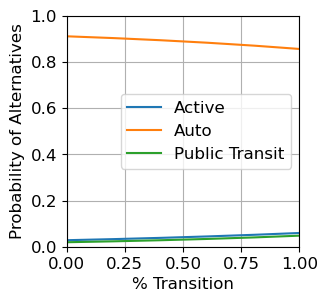

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


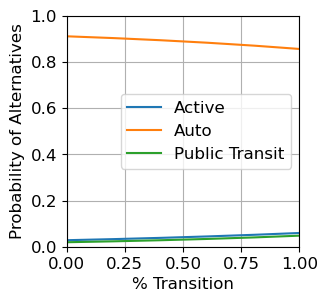

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


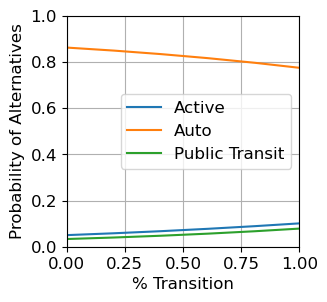

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


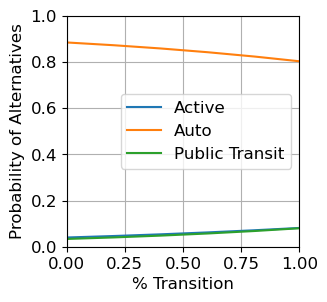

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


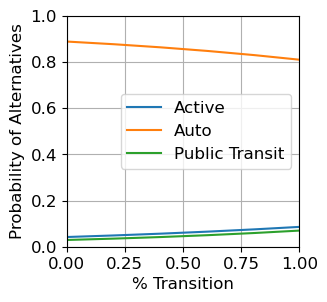

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


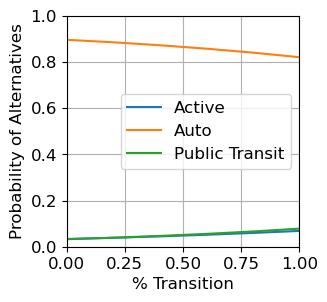

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


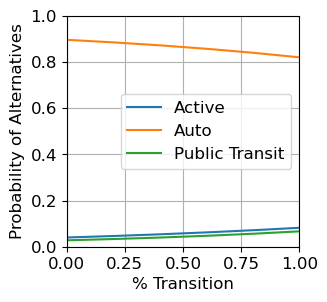

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


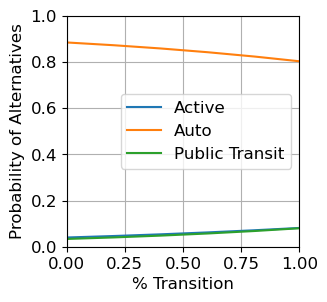

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


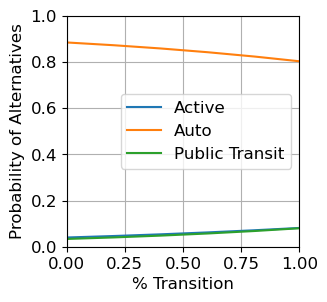

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


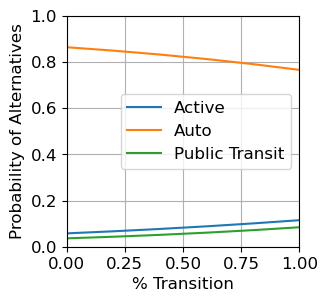

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


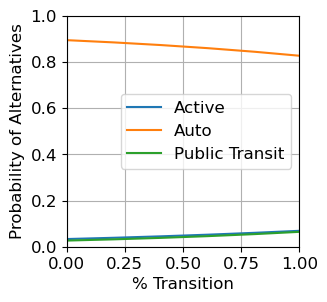

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


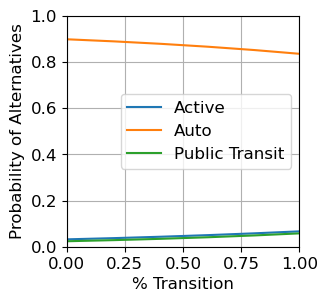

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


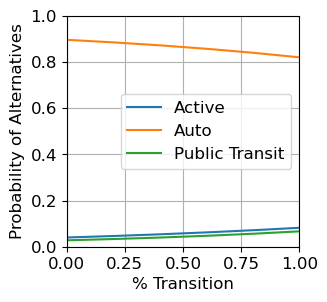

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


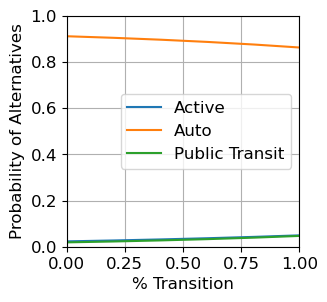

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


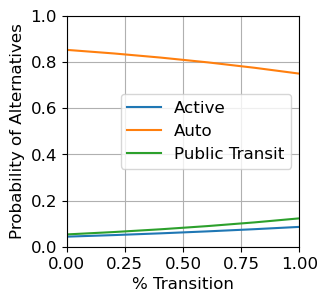

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


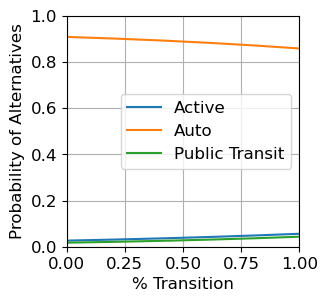

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


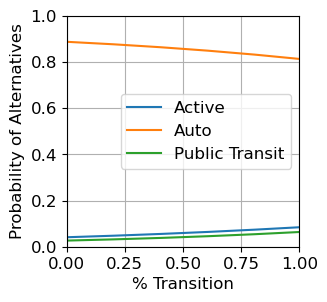

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


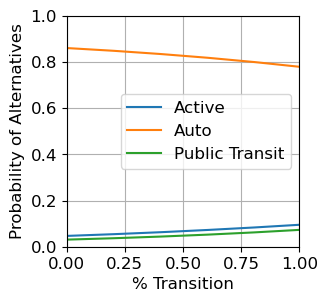

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


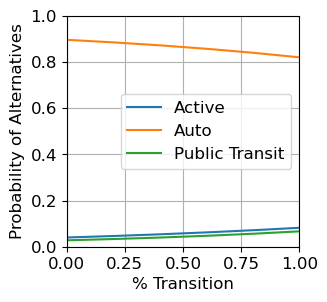

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


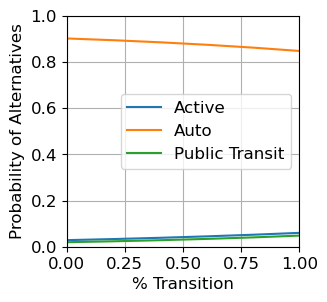

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


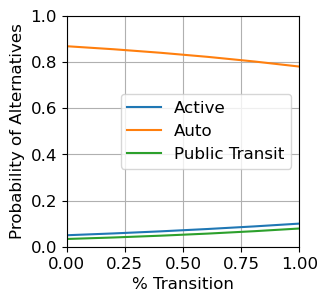

In [45]:
label = {0: "Active", 1:"Auto", 3:"Public Transit"}
for j in s1:
    select = j
    for alpha in np.linspace(0, 1, 6):
        temp = x_train[select].copy()
        temp[:dim_embed] = temp[:dim_embed] * (1-alpha) + x_train[target, :dim_embed] * (alpha)

        if alpha == 0:
            test_in = x_train[select].reshape(1, -1)
        else:
            test_in = np.concatenate([test_in, temp.reshape(1,-1)], axis=0)

    test_in = torch.tensor(test_in, dtype=torch.float32)

    fig, ax = plt.subplots(1,1, figsize=(3,3))
    probs = F.softmax(model(torch.tensor(test_in))).detach().numpy()
    
    for i in [0,1,3]:
        ax.plot(np.linspace(0,1.01,test_in.shape[0]), probs[:,i], label=label[i])
    #     print(probs[:,i])
    ax.set_ylabel("Probability of Alternatives")
    ax.set_xlabel("% Transition")
    ax.legend()
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.grid()
    plt.show()